In [ ]:
import os
import random
import sys 
import pandas as pd
import sklearn
import re
import string
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from nltk.stem import PorterStemmer
import numpy as np
import nltk
from nltk.corpus import wordnet 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer 
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report  
from sklearn import preprocessing
#from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression


ps = PorterStemmer()
all_names = names.words()
WNL = WordNetLemmatizer()
basic_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english') 
basic_stopwords = stopwords.words('english') 
punctuation = string.punctuation
lemmatizer = WordNetLemmatizer()

In [ ]:
from collections import Counter
def clean_data(df):
    #df.data =df.data.replace(to_replace='From:(.*\n)', value='', regex=True) ##remove from to email
    df.data =df.data.replace(to_replace='lines:(.*\n)', value='', regex=True)
    #df.data =df.data.replace(to_replace='Subject:(.*\n)', value='', regex=True)#remove subject
    df.data =df.data.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]', value=' ', regex=True) #remove punctuation
    df.data =df.data.replace(to_replace='-', value=' ', regex=True)
    df.data =df.data.replace(to_replace='\s+', value=' ', regex=True)    #remove new line
    df.data =df.data.replace(to_replace='  ', value='', regex=True)                #remove double white space
    df.data = df.data.replace('((www.[^s]+)|(https?://[^s]+))',value='',regex=True)
    df.data = df.data.replace(r"@\S+",value='', regex=True)                
    df.data = df.data.replace(r"\b[a-zA-Z]{1,2}\b", value="", regex=True)  
    df.data =df.data.apply(lambda x:x.strip())  # ltrim and ltrim of whitespace 
    df['data']=[entry.lower() for entry in df['data']] #to lowercase
    return df  

def custom_lemmatizer(word, pos_tag): #takes as argument the word and the pos tag
    if pos_tag.startswith("N"):
        word = wordnet_lemmatizer.lemmatize(word, wordnet.NOUN)
        return (word)
    elif pos_tag.startswith('V'):
        word = wordnet_lemmatizer.lemmatize(word, wordnet.VERB)
        return (word)
    elif pos_tag.startswith('J'):
        word = wordnet_lemmatizer.lemmatize(word, wordnet.ADJ)
        return (word)
    elif pos_tag.startswith('R'):
        word = wordnet_lemmatizer.lemmatize(word, wordnet.ADV)
        return (word)
    else:
        return word
    
def freq_words(text):
    # tokenization
    counter = Counter() 
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        counter[word]= +1

    FrequentWords = []
    number_freq_words = 5
    for (word, word_count) in counter.most_common(number_freq_words):
            FrequentWords.append(word)

    return FrequentWords

def remove_fw(text, FrequentWords):
    tokens = nltk.word_tokenize(text)
    without_fw = []
    for word in tokens:
        if word not in FrequentWords:
            without_fw.append(word)

    without_fw = ' '.join(without_fw)
    return without_fw
        
def rare_words(text):
    # tokenization
    counter = Counter() 
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        counter[word]= +1
    RareWords = []
    number_rare_words = 5
        # take top 10 frequent words
    frequentWords = counter.most_common() 
    for (word, word_count) in frequentWords[:-number_rare_words:-1]:
        RareWords.append(word)
    return RareWords

def remove_rw(text, RareWords): 
    tokens = nltk.word_tokenize(text)
    without_rw = []
    for word in tokens:
        if word not in RareWords:
            without_rw.append(word)

    without_rw = ' '.join(without_fw)
    return without_rw


def custom_preprocess(data, remove_rare = False):
    
    data = nltk.word_tokenize(data)
    remove_punctuation = str.maketrans('', '', punctuation)
    data = [word.translate(remove_punctuation) for word in data if word not in basic_stopwords ]#and word.isalnum()] #and not word.isdigit()]
    data = [lemmatizer.lemmatize(word) for word in data]
    tagged_data = nltk.pos_tag(data)
    data = [custom_lemmatizer(word[0],word[1]) for word in tagged_data] 
    data = ' '.join(data)  
    if remove_rare is True:
        RareWords = rare_words(data)
        data = remove_fw(data, RareWords)
        FrequentWords = freq_words(data) 
        data = remove_fw(data, FrequentWords)
    return data

def get_synonyms(word):
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n):

    words = words.split()

    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in basic_stopwords]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

def DataAugmentation(train_df):
    tmp_df = pd.DataFrame()
    for doc in range(0,len(train_df)):
        tmp1 = pd.DataFrame()
        label = train_df.target.iloc[doc]
        length = len(train_df.data.iloc[doc])
        tmp1 = pd.DataFrame(#creating a temporary dataframe to store the current data and target
                    {
                        'data':synonym_replacement(train_df.data.iloc[doc], length/6),
                        'target':label
                    },index=[0])
        tmp_df = pd.concat([tmp_df,tmp1])
    return pd.concat([train_df,tmp_df])


def model_Evaluate(model,y_test,x_test):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred)) 
    plot_confusion_matrix(model, x_test, y_test)  
    plt.rcParams['figure.figsize'] = [20, 20] 
    plt.show()
    
def LR_Model(x_train,y_train,x_test,y_test):
    LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
    LRmodel.fit(x_train, y_train)
    model_Evaluate(LRmodel,y_test,x_test)
    y_pred3 = LRmodel.predict(x_test)

def SGD_Model(x_train,y_train,x_test,y_test): 
    sgd_m = SGDClassifier(max_iter=2000,warm_start=True)
    sgd_m.fit(x_train, y_train)
    model_Evaluate(sgd_m,y_test,x_test)
    
def MNB_Model(x_train,y_train,x_test,y_test): 
    mnb_m = MultinomialNB(alpha=0.05)
    mnb_m.fit(x_train, y_train)
    model_Evaluate(mnb_m,y_test,x_test)  

In [ ]:
#Loading, cleaning & preprocessing data
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
test_data = fetch_20newsgroups(subset='test')

train_df = pd.DataFrame(data=train_data['data'],columns=['data'])
train_df['target'] = pd.DataFrame(data=train_data['target'])

test_df = pd.DataFrame(data=test_data['data'],columns=['data'])
test_df['target'] = pd.DataFrame(data=test_data['target'])

train_df = clean_data(train_df)
train_df.data = train_df.data.apply(lambda x:custom_preprocess(x,False))
test_df = clean_data(test_df)
test_df.data = test_df.data.apply(lambda x:custom_preprocess(x,False))
train_df = DataAugmentation(train_df)

x_train = train_df.data
y_train = train_df.target
x_test = test_df.data
y_test = test_df.target

In [ ]:
x_train = train_df.data
y_train = train_df.target
x_test = test_df.data
y_test = test_df.target
ros = RandomOverSampler()

vectorizer = TfidfVectorizer(max_features=100000)
#vectorizer = CountVectorizer(stop_words='english') 
vectorizer.fit(x_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test) 

le = preprocessing.LabelEncoder()
train_df['target'] = le.fit_transform(train_df['target'])
test_df['target']  = le.fit_transform(test_df['target'])

x_train,y_train = ros.fit_resample(x_train,y_train)
#sns.countplot(train_df['target'])

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       319
           1       0.76      0.79      0.78       389
           2       0.77      0.73      0.75       394
           3       0.76      0.72      0.74       392
           4       0.79      0.86      0.82       385
           5       0.89      0.80      0.84       395
           6       0.77      0.86      0.82       390
           7       0.93      0.89      0.91       396
           8       0.94      0.96      0.95       398
           9       0.92      0.96      0.94       397
          10       0.95      0.98      0.97       399
          11       0.92      0.94      0.93       396
          12       0.80      0.75      0.77       393
          13       0.91      0.87      0.89       396
          14       0.90      0.93      0.92       394
          15       0.84      0.93      0.88       398
          16       0.74      0.91      0.81       364
          17       0.97    

/Users/tsac/.config/miniforge/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


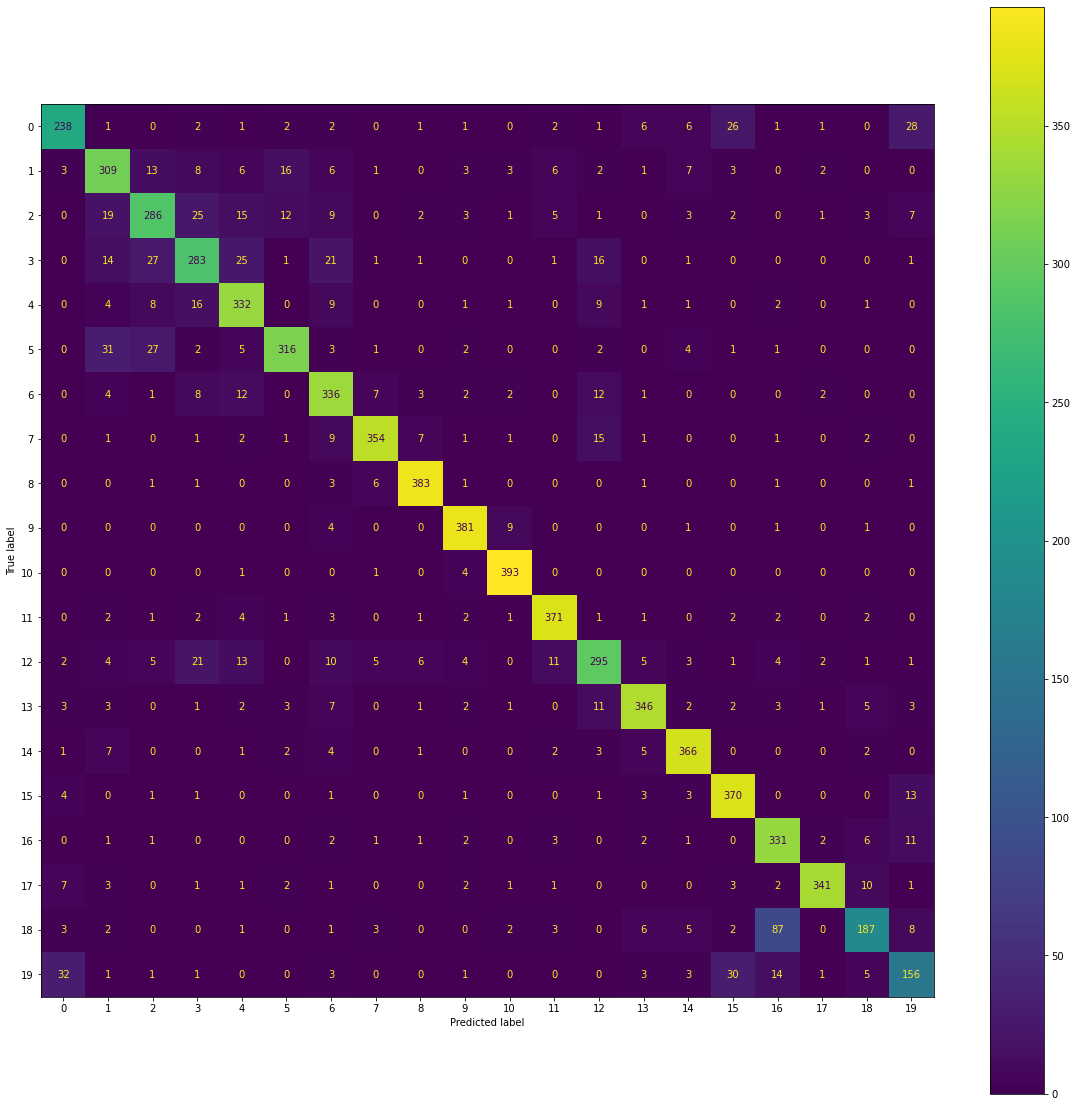

In [496]:
SGD_Model(x_train,y_train,x_test,y_test)

In [ ]:
#LR_Model(x_train,y_train,x_test,y_test)

In [ ]:
#MNB_Model(x_train,y_train,x_test,y_test)